# Generation of figure 4
Tim Tyree<br>
9.20.2022

In [1]:
# TODO: simplify initialization
from scipy.optimize import minimize
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt, numpy as np
from mpltools import annotation
import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats

#for particle params to MSR generating functional
from scipy.signal import savgol_filter
import dask.bag as db
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

#optional
# import cupy as cp
# cp.random.seed(42)
np.random.seed(42)

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [414]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [106]:
from scipy.optimize import dual_annealing

In [415]:
#reset matplotlib
mpl.rcParams.update(matplotlib.rcParamsDefault)

# define module

In [107]:
def comp_mean_bootstrap_uncertainty(x,num_samples=1000):
    """
    Example Usage:
meanx,Delta_meanx,num_obs,p_normal=comp_mean_bootstrap_uncertainty(minlifetime_values)
printing=True
if printing:
    print(f"mean: {meanx:.4f} +/- {Delta_meanx:.4f} (N={num_obs}, {p_normal=:.4f})")
    """
    meanx = np.mean(x)
    Delta_meanx,p_normal=bootstrap_95CI_Delta_mean(x,num_samples=num_samples)
    num_obs=x.shape[0]
    return meanx,Delta_meanx,num_obs,p_normal


#TODO: copy to lib.model
def comp_square_error_msr_aff_osc(x,*args):
    """phase is in radians. period is in milliseconds.  a0,a1 are in cm^2/s.

Example Usage:
x0=a0,a1,period,phase
args=t_values,msr_values,D
square_error=comp_square_error_msr_aff_osc(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"{rmse=}")
    """
    a0,a1,period,phase=x
    t_values,msr_values,D=args
    omega=2*np.pi/period*1e3 #Hz bc period is in ms
    msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
    square_error_msr=np.sum((msr_values_affoscillatory-msr_values)**2)
    return square_error_msr

def anneal_msr_fit(t_values,msr_values,D,
                   bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                   maxiter=1000,
                   seed=42,
                   no_local_search=True,
                   **kwargs):
    """returns fit of MSR(t') to the affine oscillatory particle model.
    if no_local_search=True, simulated annealing is used.
    if no_local_search=False, dual annealing is used.
    kwargs are passed to scipy.optimize.dual_annealing
    bounds gives the upper/lower bounds to parameter values a0 (cm^2/s), a1 (cm^2/s), period (ms), and phase (radians), respectively.

    Example Usage:
res = anneal_msr_fit(t_values,msr_values,D,
                   bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                   maxiter=1000,seed=42, no_local_search=True)#,**kwargs)
    """
    # input: t_values, msr_values, D, Gamma
    # output: a0,a1,period,phase,rmse,alinear
    args=t_values,msr_values,D
    # np.random.seed(42)   # seed to allow replication.
    res = dual_annealing(
        comp_square_error_msr_aff_osc,
        bounds=bounds,
        args=args,
        maxiter=maxiter,
        seed=seed,
        no_local_search=no_local_search,**kwargs)
    return res

def comp_alinear(a0,a1,period,Gamma,phase):
    """computes the effective attraction coefficient of the linear particle model.
    a0,a1 are in units of alinear. 
    period is in units of the mean minimum lifetime, Gamma. 
    phase is in units of radians.
    
    Example Usage:
alinear = comp_alinear(a0,a1,period,Gamma,phase)
    """
    omega = 2*np.pi/period
    z = Gamma*omega
    alinear=a0 + a1*(np.cos(phase)-z*np.sin(phase))/(1 + z**2)
    return alinear

In [128]:
def fit_msr_oscillatory(x_values,y_values,max_tdeath,
                        D=0., #cm^2/s
                        tscale=1e-3, #s per ms
                        maxiter=10000,
                        bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                        seed=42, 
                        no_local_search=True,
                        printing=True,
                        **kwargs):
    """inputed xy values correspond to tdeath,msd, respectively.
    bounds is the bounding box in the linear basis of (a0,a1,period,phase), respectively.
    kwargs are passed to anneal_msr_fit directly.
    
    Example Usage: print fit of oscillatory particle model to full
a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                    D=0.,maxiter=10000,printing=True)#,**kwargs)
dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse)
print_dict(dict_fit)
    """
    boo=x_values<max_tdeath
    t_values=x_values[boo].copy()*tscale
    msr_values=y_values[boo].copy() 
    msr_values-= np.min(msr_values) #corrects for aliasing
    if printing:
        print(f"performing simulated annealing with {D=:.0f} fixed (num. epochs: {maxiter})...")
    res = anneal_msr_fit(t_values,msr_values,D,
                       bounds = bounds,
                       maxiter=maxiter,seed=seed, no_local_search=no_local_search,**kwargs)
    rmse= np.sqrt(res.fun/t_values.shape[0])
    a0,a1,period,phase=res.x
    if printing:
        print(f"simulated annealing fit: {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f} --> {rmse=:.4f} cm^2")
    rmse= np.sqrt(res.fun/t_values.shape[0])
    return a0,a1,period,phase,rmse

# dev

In [111]:
#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()

input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"
input_fn_dict={'vectorsummed':input_fn,'neighboronly':input_fn}

# interp=recall_particle_model_interp(input_fn_dict=input_fn_dict)
# a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

In [112]:
# # #FK model trajectories
# # #per 005
# # annihil_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_annihilation_range_timeseries.pkl"
# # creation_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_creation_range_timeseries.pkl" # 79 trials
# # DT = 5e-3 # s / frame
# # per 001
# annihil_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl"
# creation_range_dir_fk = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_creation_range_timeseries.pkl"
# DT = 1e-3 # s / frame
# DS = 0.0025 # cm / px
# assert os.path.exists(annihil_range_dir_fk)
# assert os.path.exists(creation_range_dir_fk)
# data_annihil=load_from_pickle(annihil_range_dir_fk)
# data_creation=load_from_pickle(creation_range_dir_fk)


# df_ranges_annihiln = pd.concat(data_annihil)
# df_ranges_creation = pd.concat(data_creation)
# print(f"num. trials in cached annihilation ranges: {df_ranges_annihiln['trial_num'].max()}")
# print(f"num. trials in cached creation ranges: {df_ranges_creation['trial_num'].max()}")

# # df=df_ranges_annihiln
# # num_termination_events = df['trial_num'].max()
# # minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
# # meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
# # printing=True
# # if printing:
# #     print(f" - mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
    
# df=df_ranges_creation
# num_termination_events = df['trial_num'].max()
# minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
# meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
# printing=True
# if printing:
#     print(f"Fenton-Karma: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
    
# minlifetime_values_fk = minlifetime_values.copy()*DT

# #LR model trajectories
# #per 001
# annihil_range_dir_lr = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl"
# creation_range_dir_lr = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr//200x200/tippos_per_001_creation_range_timeseries.pkl"
# DT = 1e-3 # s / frame
# DS = 0.0025 # cm / px
# assert os.path.exists(annihil_range_dir_lr)
# assert os.path.exists(creation_range_dir_lr)
# data_annihil=load_from_pickle(annihil_range_dir_lr)
# data_creation=load_from_pickle(creation_range_dir_lr)

# df_ranges_annihiln = pd.concat(data_annihil)
# df_ranges_creation = pd.concat(data_creation)
# print(f"num. trials in cached annihilation ranges: {df_ranges_annihiln['trial_num'].max()}")
# print(f"num. trials in cached creation ranges: {df_ranges_creation['trial_num'].max()}")

# df=df_ranges_annihiln
# num_termination_events = df['trial_num'].max()
# minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
# meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
# printing=True
# if printing:
#     print(f"Luo-Rudy: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
    
# # df=df_ranges_creation
# # num_termination_events = df['trial_num'].max()
# # minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
# # meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
# # printing=True
# # if printing:
# #     print(f" - mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
    
# minlifetime_values_lr = minlifetime_values.copy()*DT

# minlifetime_values_fk.shape,minlifetime_values_lr.shape

In [113]:
#load from full models

#load msr data for FK model (200x200) (src: wj)
msr_dir_bootstrap_fk=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
range_data_dir_fk=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
df_msr_fk=pd.read_csv(msr_dir_bootstrap_fk)
#load apparent ranges
data_lst=load_from_pickle(range_data_dir_fk)
num_termination_events_fk = len(data_lst)
print(f"loaded range timeseries from {num_termination_events_fk} termination events (FK)")
df_ranges_fk=pd.concat(data_lst)
del data_lst
print(f"{df_ranges_fk.shape=}")

#load msr data for LR model (200x200) (src: wj)
msr_dir_bootstrap_lr=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'
range_data_dir_lr=f'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
df_msr_lr=pd.read_csv(msr_dir_bootstrap_lr)
#load apparent ranges
data_lst=load_from_pickle(range_data_dir_lr)
num_termination_events_lr = len(data_lst)
print(f"loaded range timeseries from {num_termination_events_lr} termination events (LR)")
df_ranges_lr=pd.concat(data_lst)
del data_lst
print(f"{df_ranges_lr.shape=}")

loaded range timeseries from 80 termination events (FK)
df_ranges_fk.shape=(3846532, 9)
loaded range timeseries from 595 termination events (LR)
df_ranges_lr.shape=(524869, 9)


In [114]:
#compute minlifetime_values
minlifetime_values_fk = df_ranges_fk.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values_fk)
printing=True
if printing:
    print(f" - FK: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events_fk} termination events")
    
minlifetime_values_lr = df_ranges_lr.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values_lr)
printing=True
if printing:
    print(f" - LR: mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events_lr} termination events")
    

 - FK: mean lifetime: 105.3196 +/- 1.6518 ms (N=36179, p_normal: 0.6193) from 80 termination events
 - LR: mean lifetime: 33.3659 +/- 0.7126 ms (N=15273, p_normal: 0.1038) from 595 termination events


In [519]:
df = df_ranges_fk.copy()
df['SR']=df['R']**2
meansqrange_values = df.groupby(by=['trial_num','annihilation_index'])['SR'].mean().values
meanSR,Delta_meanSR,num_obsSR,p_normalSR=comp_mean_bootstrap_uncertainty(meansqrange_values)
if printing:
    print(f"Fenton-Karma:")
    print(f"- mean squared range: {meanSR:.4f} +/- {Delta_meanSR:.4f} cm^2 (N={num_obsSR}, p_normal: {p_normalSR:.4f})")# from {num_termination_events} termination events")
    print(f"- root mean squared range: {np.sqrt(meanSR):.4f} +/- {0.5*np.sqrt(Delta_meanSR)/np.sqrt(meanSR):.4f} cm (N={num_obsSR}, p_normal: {p_normalSR:.4f})")# from {num_termination_events} termination events")
dict_SR_fk = dict(meanSR=meanSR,Delta_meanSR=Delta_meanSR,num_obsSR=num_obsSR,p_normalSR=p_normalSR)
    
df = df_ranges_lr.copy()
df['SR']=df['R']**2
meansqrange_values = df.groupby(by=['trial_num','annihilation_index'])['SR'].mean().values
meanSR,Delta_meanSR,num_obsSR,p_normalSR=comp_mean_bootstrap_uncertainty(meansqrange_values)
if printing:
    print(f"Luo-Rudy:")
    print(f"- mean squared range: {meanSR:.4f} +/- {Delta_meanSR:.4f} cm^2 (N={num_obsSR}, p_normal: {p_normalSR:.4f})")# from {num_termination_events} termination events")
    print(f"- root mean squared range: {np.sqrt(meanSR):.4f} +/- {0.5*np.sqrt(Delta_meanSR)/np.sqrt(meanSR):.4f} cm (N={num_obsSR}, p_normal: {p_normalSR:.4f})")# from {num_termination_events} termination events")
dict_SR_lr = dict(meanSR=meanSR,Delta_meanSR=Delta_meanSR,num_obsSR=num_obsSR,p_normalSR=p_normalSR)
    

Fenton-Karma:
- mean squared range: 0.4435 +/- 0.0067 cm^2 (N=36179, p_normal: 0.6234)
- root mean squared range: 0.6659 +/- 0.0613 cm (N=36179, p_normal: 0.6234)
Luo-Rudy:
- mean squared range: 0.7396 +/- 0.0159 cm^2 (N=15273, p_normal: 0.6808)
- root mean squared range: 0.8600 +/- 0.0733 cm (N=15273, p_normal: 0.6808)


10.0

In [ ]:


#TODO: measure 
# input: df_ranges_fk, df_ranges_lr
# output: mean squared distance betwee annihilating particles
# - ensemble then time average
# - time average then ensemble averaged

In [115]:
# bins=np.linspace(10,2500,100)*DT
# bins=np.logspace(-2,1,40)
bins=np.logspace(-2,1,40)
#DONE: compute the histograms
barheights_fk,bins_fk = np.histogram(
    minlifetime_values_fk*1e-3,
    bins=bins,#10,
    range=None,
    normed=None,
    weights=None,
    density=True,
)
x_fk=0.5*(bins_fk[1:]+bins_fk[:-1])

barheights_lr,bins_lr = np.histogram(
    minlifetime_values_lr*1e-3,
    bins=bins[bins<0.45],#10,
    range=None,
    normed=None,
    weights=None,
    density=True,
)
x_lr=0.5*(bins_lr[1:]+bins_lr[:-1])

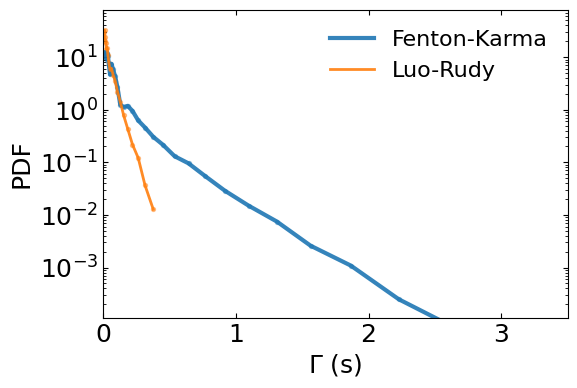

In [116]:
#DONE: compute the minimum lifetimes of particles
#TODO: plot the minimum lifetimes of particles
lw=2
alpha=0.9
fontsize=18
# use_loglog=True
use_loglog=False
#check if msd=0 at lagt=0
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(x_fk,barheights_fk,c='C0',lw=lw+1,alpha=alpha,label='Fenton-Karma')
ax.scatter(x_fk,barheights_fk,c='C0',s=8,alpha=alpha/2,zorder=0)
boolr=barheights_lr>1e-5
ax.plot(x_lr[boolr],barheights_lr[boolr],c='C1',lw=lw,alpha=alpha,label='Luo-Rudy')
ax.scatter(x_lr[boolr],barheights_lr[boolr],c='C1',s=8,alpha=alpha/2,zorder=0)

# xv1=np.linspace(0.01,0.5,10)
# xv2=np.linspace(0.1,5,10)
# ax.plot(xv1,dict_fit_lr['M']*xv1+0.,'k-',lw=2,alpha=0.7)
# ax.plot(xv2,dict_fit_fk['M']*xv2+0.,'k-',lw=2,alpha=0.7)

#format_plot
ax.set_yscale('log')
ax.set_xlim([0,3.5])
ax.set_ylim((11*1.0178650359332904e-05, 80))
format_plot(ax=ax,xlabel=r'$\Gamma$ (s)',ylabel=r'PDF',fontsize=fontsize,use_loglog=use_loglog)
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False)

plt.show()

In [117]:
#extract xy values from full
x_values_fk=df_msr_fk['tdeath_avg'].values
y_values_fk=df_msr_fk['MSR'].values
yerr_values_fk=df_msr_fk['Delta_MSR'].values
x_values_lr=df_msr_lr['tdeath_avg'].values
y_values_lr=df_msr_lr['MSR'].values
yerr_values_lr=df_msr_lr['Delta_MSR'].values

In [438]:
##################################################################
# compute simulated annealing fits of oscillatory particle model
##################################################################
D=0.
print(f"fixed {D=:.4f} cm^2/s.")
print(f"computing simulated annealing fits of oscillatory particle model to the Fenton-Karma model...")
# select msr from the full models for fitting
x_values=x_values_fk.copy()
y_values=y_values_fk.copy()
minlifetime_values=minlifetime_values_fk.copy()

#### 

# max_tdeath=100. #ms #for lr
max_tdeath=300. #ms #for fk
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
Gamma=float(meanx)
testing=False 
# testing=True # True adds ~60 - 6.27 seconds to runtime
if printing:
    print(f"mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {minlifetime_values.shape[0]} termination events")
#fit using simulated annealing
a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                    D=0.,maxiter=10000,seed=42,printing=printing)
alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,
              alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
if not testing:
    print_dict(dict_fit)

if testing:
    print(f"performing fit using simulated annealing with 10X the number of learning rounds...")
    a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                        D=0.,maxiter=100000,seed=43,printing=printing)
    alinear = comp_alinear(a0,a1,period,Gamma,phase)
    omega = 2*np.pi/period
    z = Gamma*omega
    print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
    dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,
                  alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
    print_dict(dict_fit)    
    
dict_osc_fit_fk=dict(dict_fit)

#### 
print(f"\ncomputing simulated annealing fits of oscillatory particle model to the Luo-Rudy model...")
# select msr from the full models for fitting
x_values=x_values_lr.copy()
y_values=y_values_lr.copy()
minlifetime_values=minlifetime_values_lr.copy()
max_tdeath=100. #ms #for lr
# max_tdeath=300. #ms #for fk
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
Gamma=float(meanx)
# testing=False 
# testing=True # True adds ~60 - 6.27 seconds to runtime
if printing:
    print(f"mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {minlifetime_values.shape[0]} termination events")
#fit using simulated annealing
a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                    D=0.,maxiter=10000,seed=42,printing=printing)
alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,
              alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
if not testing:
    print_dict(dict_fit)

if testing:
    print(f"performing fit using simulated annealing with 10X the number of learning rounds...")
    a0,a1,period,phase,rmse = fit_msr_oscillatory(x_values,y_values,max_tdeath,
                                        D=0.,maxiter=100000,seed=43,printing=printing)
    alinear = comp_alinear(a0,a1,period,Gamma,phase)
    omega = 2*np.pi/period
    z = Gamma*omega
    print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
    dict_fit=dict(a0=a0,a1=a1,period=period,phase=phase,rmse=rmse,
                  alinear=alinear,omega=omega,z=z,Gamma=Gamma, Delta_Gamma=Delta_meanx, num_obs=num_obsx, p_normal=p_normalx)
    print_dict(dict_fit)    

dict_osc_fit_lr=dict(dict_fit)

##nota bene: the contents of fit_msr_oscillatory:
# maxiter=100000
# print(f"num. epochs: {maxiter}")
# res = anneal_msr_fit(t_values,msr_values,D,
#                    bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
#                    maxiter=maxiter,seed=42+1, no_local_search=True)#,**kwargs)
# rmse= np.sqrt(res.fun/t_values.shape[0])
# a0,a1,period,phase=res.x
# print(f"simulated annealing fit: {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f} --> {rmse=:.4f} cm^2")


fixed D=0.0000 cm^2/s.
computing simulated annealing fits of oscillatory particle model to the Fenton-Karma model...
mean lifetime: 105.3196 +/- 1.6814 ms (N=36179, p_normal: 0.4745) from 36179 termination events
performing simulated annealing with D=0 fixed (num. epochs: 10000)...
simulated annealing fit: a0=1.6362, a1=1.2822, period=115.9413, phase=-0.5415 --> rmse=0.0284 cm^2
	attraction coefficient: a0=1.6362, a1=1.2822, z=5.7076, phase=-0.5415 --> alinear=1.7812 cm^2/s
a0=1.6361678784211904
a1=1.2822207795221772
period=115.94132757652915
phase=-0.5414831911503737
rmse=0.028433802911998075
alinear=1.7812325245076142
omega=0.054192801122035256
z=5.707561428236097
Gamma=105.31955001520218
Delta_Gamma=1.681395888782862
num_obs=36179
p_normal=0.474524891672195

computing simulated annealing fits of oscillatory particle model to the Luo-Rudy model...
mean lifetime: 33.3659 +/- 0.7314 ms (N=15273, p_normal: 0.5136) from 15273 termination events
performing simulated annealing with D=0 fix

{'a0': 5.019074730387047,
 'a1': 12.179828386551463,
 'period': 97.35933142725673,
 'phase': -1.1654637833257504,
 'rmse': 0.06416619326476351,
 'alinear': 10.146975509029975,
 'omega': 0.06453603588962757,
 'z': 2.153305494485853,
 'Gamma': 33.36593989393047,
 'Delta_Gamma': 0.7314268517462866,
 'num_obs': 15273,
 'p_normal': 0.5135685773078689}

In [439]:
##################################################################################################
# compute the direct simulation of the oscillatory particle model under these parameter settings
##################################################################################################

In [178]:
print(f"integrating oscillatory stochastic differential equation directly (estimated run time ~45 seconds)...")
a=dict_osc_fit_fk['a1']
D=dict_osc_fit_fk['a0']/2
initial_phase_orientation=dict_osc_fit_fk['phase']
period_of_oscillation=dict_osc_fit_fk['period']
#compute the oscillatory particle model
kwargs_fk=dict(a=a, D=D, initial_phase_orientation=initial_phase_orientation, period_of_oscillation=period_of_oscillation, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
dict_fit_fk=visualize_model_oscillatory_reversed(ax=None,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
plt.close()
print(*dict_fit_fk)

integrating oscillatory stochastic differential equation directly (estimated run time ~45 seconds)...
m Delta_m b Delta_b Rsquared title tdeath MSR


In [221]:
print(f"integrating oscillatory stochastic differential equation directly (estimated run time 1 minutes and 40 seconds)...")
# print(f"integrating oscillatory stochastic differential equation directly (estimated run time ~40 seconds)...")
a=dict_osc_fit_lr['a1']
D=dict_osc_fit_lr['a0']/2
initial_phase_orientation=dict_osc_fit_lr['phase']
period_of_oscillation=dict_osc_fit_lr['period']
#compute the oscillatory particle model
kwargs_lr=dict(a=a, D=D, initial_phase_orientation=initial_phase_orientation, period_of_oscillation=period_of_oscillation, 
               num_pairs=1000,  # no clear difference for num_pairs=2000, ...
               rstart=0.0001, 
               Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
dict_fit_lr=visualize_model_oscillatory_reversed(ax=None,c='C1',label='Simulation of Osc. (LR)', **kwargs_lr)
plt.close()
print(*dict_fit_lr)

integrating oscillatory stochastic differential equation directly (estimated run time 1 minutes and 40 seconds)...
m Delta_m b Delta_b Rsquared title tdeath MSR


In [217]:
# initial_phase_orientation
# #what param setting to use for the FK model?
# phi_f=initial_phase_orientation
# period=period_of_oscillation*1e3 #seconds
# # constant=0.15
# omega=2*np.pi/period
# # constant=-8*D*np.sin(phi_f)/omega#0.15

In [222]:
#plot expected
lw=2
alpha=0.4
fontsize=16
# # figsize=(8,4.2)
# figsize=(4,4.2)
figsize=(6,4)
fontsize=15
### plot expected
fontsize=20
tscale=1e-3

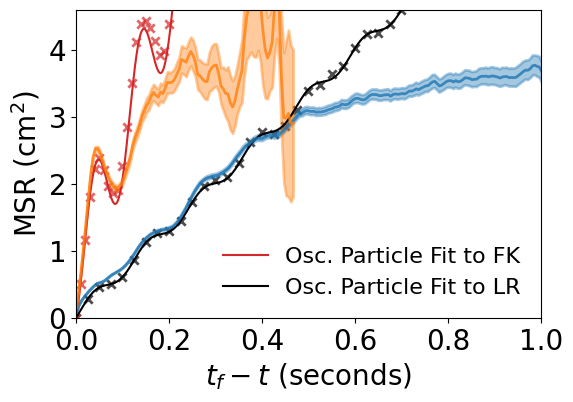

In [226]:
#plot MSR_Osc over the direct simulation results
fig,ax=plt.subplots(figsize=(6,4))
#plot simulated annealing fits of oscillatory particle model
phi_f = dict_osc_fit_lr['phase']
omega = dict_osc_fit_lr['omega']*1e3
a = dict_osc_fit_lr['a1']
D = dict_osc_fit_lr['a0']/2
t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'Osc. Particle Fit to FK')
#                 label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')
phi_f = dict_osc_fit_fk['phase']
omega = dict_osc_fit_fk['omega']*1e3
a = dict_osc_fit_fk['a1']
D = dict_osc_fit_fk['a0']/2
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*(np.sin(omega*t_values+phi_f))+constant
MSR_values_oscillatory=4*(2*D*t_values+(a/omega)*(np.sin(omega*t_values+phi_f)-np.sin(phi_f)))
ax.plot(t_values,MSR_values_oscillatory,c='k',#'C2',
                label=r'Osc. Particle Fit to LR')


#plot the direct simulation of the oscillatory particle model under these same parameter settings
stepsize=2500
plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='k',#'C2',
            marker='x')#,label='Simulation of Osc. (FK)')
stepsize=1000
plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C3',
            marker='x')#,label='Simulation of Osc. (LR)')


#plot msd data from full
ax.plot(x_values_fk*tscale,y_values_fk,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_fk*tscale,y_values_fk-yerr_values_fk,y_values_fk+yerr_values_fk,lw=lw,alpha=alpha,color='C0')
ax.plot(x_values_lr*tscale,y_values_lr,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_lr*tscale,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,lw=lw,alpha=alpha,color='C1')


#format_plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
plt.legend(fontsize=16,frameon=False)


# plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.6])
# plt.ylim([0,5.1])
# plt.ylim([0,14.1])
plt.show()

In [561]:
dffk=pd.DataFrame([dict_osc_fit_fk])
dflr=pd.DataFrame([dict_osc_fit_lr])
dffk['model']='Fenton-Karma'
dflr['model']='Luo-Rudy'
df_osc_fits = pd.concat((dffk,dflr))
df_osc_fits['amax'] = df_osc_fits['alinear'] 
# list(df_osc_fits.columns)
# df_osc_fits = df_osc_fits[['model', 'amax', 'a0', 'a1', 'period', 'phase', 'rmse', 'omega', 'z']].copy().T
df_osc_fits = df_osc_fits[['model', 'amax', 'a0', 'a1', 'period', 'phase', 'z', 'rmse']].copy().T
print("%simulated annealing fits:")
print(df_osc_fits.to_latex())

%simulated annealing fits:
\begin{tabular}{lll}
\toprule
{} &             0 &          0 \\
\midrule
model  &  Fenton-Karma &   Luo-Rudy \\
amax   &      1.781233 &  10.146976 \\
a0     &      1.636168 &   5.019075 \\
a1     &      1.282221 &  12.179828 \\
period &    115.941328 &  97.359331 \\
phase  &     -0.541483 &  -1.165464 \\
z      &      5.707561 &   2.153305 \\
rmse   &      0.028434 &   0.064166 \\
\bottomrule
\end{tabular}



# plot the phases for an insetted pie chart indicating the final phases

In [312]:
from matplotlib.lines import Line2D
from matplotlib.patches import Arc
# from math import degrees
import math

In [380]:
phase_fk = dict_osc_fit_fk['phase']
phase_lr = dict_osc_fit_lr['phase']
print(f"{phase_fk=} radians")
print(f"{phase_lr=} radians")

phase_fk=-0.5414831911503737 radians
phase_lr=-1.1654637833257504 radians


In [381]:
def get_angle_plot(line1, line2, offset = 1, color = None, origin = [0,0], len_x_axis = 1, len_y_axis = 1):

    l1xy = line1.get_xydata()

    # Angle between line1 and x-axis
    slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle

    l2xy = line2.get_xydata()

    # Angle between line2 and x-axis
    slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color, label = str(angle)+u"\u00b0")

In [382]:
def get_angle_text(angle_plot):
    angle = angle_plot.get_label()[:-1] # Excluding the degree symbol
    angle = "%0.2f"%float(angle)+u"\u00b0" # Display angle upto 2 decimal places

    #get the vertices of the angle arc
    vertices = angle_plot.get_verts()

    #get the midpoint of the arc extremes
    x_width = (vertices[0][0] + vertices[-1][0]) / 2.0
    y_width = (vertices[0][1] + vertices[-1][1]) / 2.0
    separation_radius = max(x_width/2.0, y_width/2.0)
    return [ x_width + separation_radius, y_width + separation_radius, angle]       

In [383]:
# phase_fk=np.pi/2
# phase_lr=np.pi/2

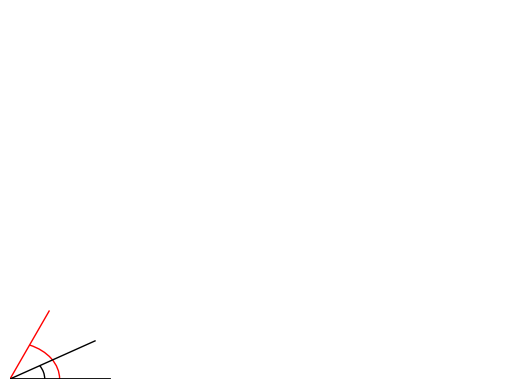

In [402]:
fig = plt.figure()
line_0 = Line2D([0,1], [0,0], linewidth=2, linestyle = "-", color="k")

x1=np.cos(phase_fk)
y1=np.sin(-phase_fk)
line_1 = Line2D([0,x1], [0,y1], linewidth=1, linestyle = "-", color='k')#"C0")
x2=np.cos(phase_lr)
y2=np.sin(-phase_lr)
line_2 = Line2D([0,x2], [0,y2], linewidth=1, linestyle = "-", color='r')#"C1")

ax = fig.add_subplot(1,1,1)

ax.add_line(line_2)
ax.add_line(line_1)
ax.add_line(line_0)

angle_plot1 = get_angle_plot(line_1, line_0, .7)
angle_text1 = get_angle_text(angle_plot1) 
angle_plot2 = get_angle_plot(line_2, line_0, 1)
angle_text2 = get_angle_text(angle_plot2) 

ax.add_patch(angle_plot1) # To display the angle arc
# ax.text(*angle_text1) # To display the angle value
ax.add_patch(angle_plot2) # To display the angle arc
# ax.text(*angle_text2) # To display the angle value
# ax.set_xlim(-7,7)
ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.axis('off')
plt.show()

In [308]:
# anglenp
# ax = plt.gca()
# line, = ax.plot([0, 0, 2], [np.cos(angle), np.sin(angle), 0], 'ro-', lw=2)
# add_corner_arc(ax, line, text=u'%d\u00b0' % 90)

# TODO: plot the universal fit

In [456]:
dict_osc_fit = dict(dict_osc_fit_fk)
alinear_fk = comp_alinear(a0=dict_osc_fit['a0'],
                       a1=dict_osc_fit['a1'],
                       period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma'],
                       phase=dict_osc_fit['phase'])
alinear_fk_min= comp_alinear(a0=dict_osc_fit['a0'],a1=dict_osc_fit['a1'],period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma']+dict_osc_fit['Delta_Gamma'],
                       phase=dict_osc_fit['phase'])
alinear_fk_max= comp_alinear(a0=dict_osc_fit['a0'],a1=dict_osc_fit['a1'],period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma']-dict_osc_fit['Delta_Gamma'],
                       phase=dict_osc_fit['phase'])
alinear_fk_min,alinear_fk,alinear_fk_max

#with gamma values as x
Gamma_values = np.linspace(1,200,1000)
x_lst=[]
y_lst=[]
for Gamma in Gamma_values:
    phase=dict_osc_fit['phase']
    period=dict_osc_fit['period']
    alinear = comp_alinear(a0=dict_osc_fit['a0'],
                       a1=dict_osc_fit['a1'],
                       period=period,
                       Gamma=Gamma,
                       phase=phase)
    z = 2*np.pi*Gamma/(period)
    #record
    x_lst.append(z) #z
    y_lst.append(alinear) #alinear
z_values_fk=np.array(x_lst)
alinear_values_fk=np.array(y_lst)

In [457]:
period=dict_osc_fit['period']
Gamma=dict_osc_fit['Gamma']
Delta_Gamma=dict_osc_fit['Delta_Gamma']
z_fk = 2*np.pi*Gamma/period
z_fk_min = 2*np.pi*(Gamma-Delta_Gamma)/period
z_fk_max = 2*np.pi*(Gamma+Delta_Gamma)/period

In [474]:
dict_osc_fit = dict(dict_osc_fit_lr)
alinear_lr = comp_alinear(a0=dict_osc_fit['a0'],
                       a1=dict_osc_fit['a1'],
                       period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma'],
                       phase=dict_osc_fit['phase'])
alinear_lr_min= comp_alinear(a0=dict_osc_fit['a0'],a1=dict_osc_fit['a1'],period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma']+dict_osc_fit['Delta_Gamma'],
                       phase=dict_osc_fit['phase'])
alinear_lr_max= comp_alinear(a0=dict_osc_fit['a0'],a1=dict_osc_fit['a1'],period=dict_osc_fit['period'],
                       Gamma=dict_osc_fit['Gamma']-dict_osc_fit['Delta_Gamma'],
                       phase=dict_osc_fit['phase'])

#with gamma values as x
Gamma_values = np.linspace(1,300,1000)
x_lst=[]
y_lst=[]
for Gamma in Gamma_values:
    phase=dict_osc_fit['phase']
    period=dict_osc_fit['period']
    alinear = comp_alinear(a0=dict_osc_fit['a0'],
                       a1=dict_osc_fit['a1'],
                       period=period,
                       Gamma=Gamma,
                       phase=phase)
    z = 2*np.pi*Gamma/(period)
    #record
    x_lst.append(z) #z
    y_lst.append(alinear) #alinear
z_values_lr=np.array(x_lst)
alinear_values_lr=np.array(y_lst)

period=dict_osc_fit['period']
Gamma=dict_osc_fit['Gamma']
Delta_Gamma=dict_osc_fit['Delta_Gamma']
z_lr = 2*np.pi*Gamma/period
z_lr_min = 2*np.pi*(Gamma-Delta_Gamma)/period
z_lr_max = 2*np.pi*(Gamma+Delta_Gamma)/period

In [483]:
y_values_fk = (alinear_values_fk - dict_osc_fit_fk['a0'])/dict_osc_fit_fk['a1']
y_values_lr = (alinear_values_lr - dict_osc_fit_lr['a0'])/dict_osc_fit_lr['a1']

y_fk = (alinear_fk - dict_osc_fit_fk['a0'])/dict_osc_fit_fk['a1']
y_fk_min = (alinear_fk_min - dict_osc_fit_fk['a0'])/dict_osc_fit_fk['a1']
y_fk_max = (alinear_fk_max - dict_osc_fit_fk['a0'])/dict_osc_fit_fk['a1']

y_lr = (alinear_lr - dict_osc_fit_lr['a0'])/dict_osc_fit_lr['a1']
y_lr_min = (alinear_lr_min - dict_osc_fit_lr['a0'])/dict_osc_fit_lr['a1']
y_lr_max = (alinear_lr_max - dict_osc_fit_lr['a0'])/dict_osc_fit_lr['a1']

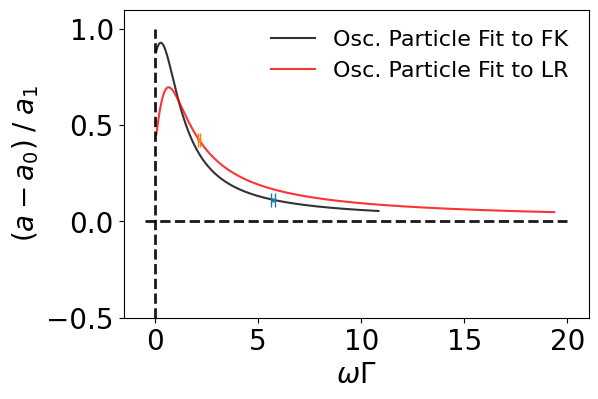

In [508]:
fig,ax=plt.subplots(figsize=(6,4))
# xlabel='z'
xlabel=r'$\omega\Gamma$'
ylabel=r'$( a-a_0 )\;/\; a_1$'
# ylabel=r'$\frac{a-a_0}{a_1}$'

ax.plot(z_values_fk,y_values_fk,c='k',alpha=0.8,label=r'Osc. Particle Fit to FK')#)#,c='C0')
ax.plot(z_values_lr,y_values_lr,c='r',alpha=0.8,label=r'Osc. Particle Fit to LR')#)#,c='C1')


#plot measurement + errorbar uncertainty for the FK model (blue)
ax.errorbar(x=z_fk, 
            y=y_fk, 
            xerr=0.5*(z_fk_max-z_fk_min), 
#             yerr=0.5*(y_fk_max-y_fk_min), 
            fmt='o',markersize=2,capsize=5,lw=2,
            color='C0')
#             label='Fenton-Karma')
#             label=r'Osc. Particle Fit to FK')

#plot measurement + errorbar uncertainty for the LR model (orange)
ax.errorbar(x=z_lr, 
            y=y_lr, 
            xerr=0.5*(z_lr_max-z_lr_min), 
#             yerr=0.5*(y_lr_max-y_lr_min), 
            fmt='o',markersize=2,capsize=5,lw=2,
            color='C1')
# #             label='Luo-Rudy')
#             label=r'Osc. Particle Fit to LR')

#plot dotted line at y-axis=0 (black)
xv=np.linspace(-0.5,20,10)
ax.plot(xv,0.*xv,'k--',alpha=0.9,lw=2)
#plot dotted line at x-axis=0 (black)
xv=np.linspace(-0.5,1,10)
ax.plot(0.*xv,xv,'k--',alpha=0.9,lw=2)


#format_plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
plt.legend(fontsize=16,frameon=False)


format_plot(ax=ax,xlabel=xlabel, ylabel=ylabel,fontsize=fontsize)
ax.set_ylim(-0.5,1.1)
plt.show()
# plt.yscale('log')

# TODO: print table of particle properties

In [532]:
#DONE: add symbols for full models
#DONE: update fig. 4
#TODO: update table in main text in the form
# symbol | description | Fenton-Karma measurement | Luo-Rudy Measurement
# ----------------------------------------------------------------------
# Gamma | Mean minimum lifetime | ?? | ?? etc...

0.0

In [548]:
kwargs_table_1_level=dict(float_format="{:0.4f}".format,
#                           multicolumn_format='c',
                           column_format='c',
#                            caption=('Table. ?? shows full\_caption', 'Table. ?? short\_caption.'),
#                            longtable=True #Requires adding a usepackage{longtable} to your LaTeX preamble.
                          )
kwargs_table_2_levels=dict(float_format="{:0.4f}".format,
                          multicolumn_format='c',
#                            column_format='c',
#                            caption=('Table. ?? shows full\_caption', 'Table. ?? short\_caption.'),
#                            longtable=True #Requires adding a usepackage{longtable} to your LaTeX preamble.
                          )

In [568]:
dffk=pd.DataFrame([dict_osc_fit_fk])
dflr=pd.DataFrame([dict_osc_fit_lr])
dffk['model']='Fenton-Karma'
dflr['model']='Luo-Rudy'
df_osc_fits = pd.concat((dffk,dflr))
df_osc_fits['amax'] = df_osc_fits['alinear'] 
# list(df_osc_fits.columns)
# df_osc_fits = df_osc_fits[['model', 'amax', 'a0', 'a1', 'period', 'phase', 'rmse', 'omega', 'z']].copy().T
# df_osc_fits = df_osc_fits[['model', 'amax', 'a0', 'a1', 'period', 'phase', 'z', 'rmse']].copy().T
df_osc_fits = df_osc_fits.set_index('model',drop=True)[['amax', 'a0', 'a1', 'period', 'phase', 'z', 'rmse']].copy().T
print("%simulated annealing fits:")
print("% \\begin{ruledtabular}")
print("% \\begin{tabular}{cccccc}")
print(df_osc_fits.to_latex(index=True, 
                                caption='Table of oscillatory particle properties for spiral tip from the full models.}\label{tab:properties}',
                                     **kwargs_table_1_level))

%simulated annealing fits:
% \begin{ruledtabular}
% \begin{tabular}{cccccc}
\begin{table}
\centering
\caption{Table of oscillatory particle properties for spiral tip from the full models.}\label{tab:properties}}
\begin{tabular}{c}
\toprule
model &  Fenton-Karma &  Luo-Rudy \\
\midrule
amax   &        1.7812 &   10.1470 \\
a0     &        1.6362 &    5.0191 \\
a1     &        1.2822 &   12.1798 \\
period &      115.9413 &   97.3593 \\
phase  &       -0.5415 &   -1.1655 \\
z      &        5.7076 &    2.1533 \\
rmse   &        0.0284 &    0.0642 \\
\bottomrule
\end{tabular}
\end{table}



In [552]:
#format table of fitted parameter values
L=5.0
D=0
dict_osc_fit_fk['num_termination_events']=num_termination_events_fk
dict_osc_fit_lr['num_termination_events']=num_termination_events_lr
dict_properties_fk=dict(dict_osc_fit_fk)
dict_properties_lr=dict(dict_osc_fit_lr)
dict_properties_fk['L']=L
dict_properties_lr['L']=L
dict_properties_fk.update(dict_SR_fk)
dict_properties_lr.update(dict_SR_lr)
dict_properties_fk['model']='Fenton-Karma'
dict_properties_lr['model']='Luo-Rudy'
df_properties = pd.DataFrame([dict_properties_fk,dict_properties_lr])
df_properties['amax']=df_properties['alinear'] + 2*D

print(f"Table of simulated annealing fits of oscillatory particle model to full models.")
print(df_properties[['model','amax','L','rmse']])

Table of simulated annealing fits of oscillatory particle model to full models.
          model       amax    L      rmse
0  Fenton-Karma   1.781233  5.0  0.028434
1      Luo-Rudy  10.146976  5.0  0.064166


In [536]:
annihil_fits_dir='/Users/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.25.29.csv'
df_annihil_fits = pd.read_csv(annihil_fits_dir)
df_annihil_fits
print(f"Table of maximum likelihood fits of linear particle model to full models.")
print(df_annihil_fits[['model','amax','L','rmse']])

Table of maximum likelihood fits of linear particle model to full models.
          model    amax     L      rmse
0  Fenton-Karma   1.781   5.0  0.140241
1  Fenton-Karma   1.780  10.0  0.190422
2      Luo-Rudy  10.149   5.0  0.194177
3      Luo-Rudy  10.147  10.0  0.119033


In [558]:
print("\n% df_table_properties")
print(f"% \caption{{Table of spiral tip properties for the full models.}}")
df_table_properties=df_properties.sort_values(by='model')\
                .set_index('model')[['amax','L','rmse','meanSR','Delta_meanSR']].T
print(df_table_properties)


% df_table_properties
% \caption{Table of spiral tip properties for the full models.}
model         Fenton-Karma   Luo-Rudy
amax              1.781233  10.146976
L                 5.000000   5.000000
rmse              0.028434   0.064166
meanSR            0.443453   0.739637
Delta_meanSR      0.006668   0.015910


In [557]:
print("\n% df_table_properties_brief")
print(f"% \caption{{Brief table of spiral tip properties for the full models.}}")
df_table_properties_brief=df_properties.sort_values(by='model')\
                .set_index('model')[['amax','L','rmse']]
# print(df_table_properties_brief)
print("% \\begin{ruledtabular}")
print("% \\begin{tabular}{cccccc}")
print(df_table_properties_brief.reset_index().to_latex(index=False, 
                                                   caption='Brief table of spiral tip properties for the full models.}\label{tab:df_table_properties_complete}',
                                                   **kwargs_table_1_level))#kwargs_table_2_levels))



% df_table_properties_brief
% \caption{Brief table of spiral tip properties for the full models.}
% egin{ruledtabular}
% egin{tabular}{cccccc}
\begin{table}
\centering
\caption{Brief table of spiral tip properties for the full models.}\label{tab:df_table_properties_complete}}
\begin{tabular}{c}
\toprule
       model &    amax &      L &   rmse &  meanSR &  Delta\_meanSR \\
\midrule
Fenton-Karma &  1.7812 & 5.0000 & 0.0284 &  0.4435 &        0.0067 \\
    Luo-Rudy & 10.1470 & 5.0000 & 0.0642 &  0.7396 &        0.0159 \\
\bottomrule
\end{tabular}
\end{table}



In [578]:
# #format as pandas table
mindex_lst=['model', 'L']
df_fit = df_annihil_fits.sort_values(by=mindex_lst,ascending=False)\
               .set_index(mindex_lst)
df_fit['delta'] = np.pi*df_fit['r']**2*df_fit['kappa']
df_params_linear=df_fit[['r','kappa', 'delta','D']].T
# print(df_params_linear)
print("\n% df_params_linear")
print("% \begin{ruledtabular}")
print("% \begin{tabular}{cccccc}")
print(df_params_linear.reset_index().to_latex(index=False, 
                                                   caption='Table of properties of the linear particle model fit to mean pair-annihilation rates of the full models.}\label{tab:df_table_properties_complete',
                                                   **kwargs_table_2_levels))#kwargs_table_1_level))#


% df_params_linear
% egin{ruledtabular}
% egin{tabular}{cccccc}
\begin{table}
\centering
\caption{Table of properties of the linear particle model fit to mean pair-annihilation rates of the full models.}\label{tab:df_table_properties_complete}
\begin{tabular}{lrrrr}
\toprule
index & \multicolumn{2}{c}{Luo-Rudy} & \multicolumn{2}{c}{Fenton-Karma} \\
      &     10.0 &      5.0 &         10.0 &      5.0 \\
\midrule
    r &   0.1400 &   0.1000 &       0.0950 &   0.0200 \\
kappa & 350.0000 & 370.0000 &     250.0000 & 880.0000 \\
delta &  21.5513 &  11.6239 &       7.0882 &   1.1058 \\
    D &   0.0500 &   0.0900 &       0.0500 &   0.1140 \\
\bottomrule
\end{tabular}
\end{table}



In [579]:
np.sqrt(0.443453)     , np.sqrt(0.739637)

(0.6659226681830256, 0.860021511358873)

In [547]:
print("\n% df_table_properties_complete")
print(f"% \caption{{Supplementary table of spiral tip properties for the full models.}}")
df_table_properties_complete=df_properties.sort_values(by='model')\
                .set_index('model').T
print(df_table_properties_complete)


% df_table_properties_complete
% \caption{Supplementary table of spiral tip properties for the full models.}
model                   Fenton-Karma      Luo-Rudy
a0                          1.636168      5.019075
a1                          1.282221     12.179828
period                    115.941328     97.359331
phase                      -0.541483     -1.165464
rmse                        0.028434      0.064166
alinear                     1.781233     10.146976
omega                       0.054193      0.064536
z                           5.707561      2.153305
Gamma                     105.319550     33.365940
Delta_Gamma                 1.681396      0.731427
num_obs                 36179.000000  15273.000000
p_normal                    0.474525      0.513569
num_termination_events     80.000000    595.000000
L                           5.000000      5.000000
meanSR                      0.443453      0.739637
Delta_meanSR                0.006668      0.015910
num_obsSR              

In [569]:
print("\n% df_table_properties_complete")
print("% \begin{ruledtabular}")
print("% \begin{tabular}{cccccc}")
print(df_table_properties_complete.reset_index().to_latex(index=False, 
                                                   caption='Supplementary table of spiral tip properties for the full models.}\label{tab:df_table_properties_complete',
                                                   **kwargs_table_1_level))#kwargs_table_2_levels))



% df_table_properties_complete
% egin{ruledtabular}
% egin{tabular}{cccccc}
\begin{table}
\centering
\caption{Supplementary table of spiral tip properties for the full models.}\label{tab:df_table_properties_complete}
\begin{tabular}{c}
\toprule
                 index &  Fenton-Karma &   Luo-Rudy \\
\midrule
                    a0 &        1.6362 &     5.0191 \\
                    a1 &        1.2822 &    12.1798 \\
                period &      115.9413 &    97.3593 \\
                 phase &       -0.5415 &    -1.1655 \\
                  rmse &        0.0284 &     0.0642 \\
               alinear &        1.7812 &    10.1470 \\
                 omega &        0.0542 &     0.0645 \\
                     z &        5.7076 &     2.1533 \\
                 Gamma &      105.3196 &    33.3659 \\
           Delta\_Gamma &        1.6814 &     0.7314 \\
               num\_obs &    36179.0000 & 15273.0000 \\
              p\_normal &        0.4745 &     0.5136 \\
num\_termination\_events 

### fits of D from MSD

(Fenton-Karma) msd powerlaw fit of msd from lagt=0.1 to 3:
- m = 1.001994 +/- 0.015057
- M = 0.005766 +/- 0.000384 Hz/cm^2; B=0.005826 +/- 0.000076
- RMSE=0.0008 Hz/cm^2; R^2=0.9921; N=138
- D = 0.0014 +/- 0.0001 cm^2/s

(Luo-Rudy) msd powerlaw fit of msd from lagt=0.06 to 0.2:
- m = 0.981067 +/- 0.044880
- M = 0.148857 +/- 0.005591 Hz/cm^2; B=0.143485 +/- 0.007501
- RMSE=0.0011 Hz/cm^2; R^2=0.9750; N=49
- D = 0.0372 +/- 0.0014 cm^2/s

src: http://localhost:8889/notebooks/demonstration%20of%20brownian%20behaviour.ipynb



### fits of alinear from dR/dt 

(Fenton-Karma) linear fit of dRdt from 1/R=0.0 to 10:
- m=-4.550823917522961
- Delta_m=0.8299672832720622
- b=-0.7883724177008169
- Delta_b=1.5044154352605568
- Rsquared=0.7674370424368964
- num_obs=37
- rmse=3.1625294434003433
- Rsq=0.7674370424368964
- ahat = 2.2754 +/- 0.4150 cm^2/s

(Luo-Rudy) linear fit of dRdt from 1/R=0.0 to 10:
- m=-8.087927742495596
- Delta_m=0.4593631505563615
- b=-2.310333356275457
- Delta_b=0.7439196689530453
- Rsquared=0.9635892116333213
- num_obs=47
- rmse=1.8623782485431748
- Rsq=0.9635892116333213
- ahat = 4.0440 +/- 0.2297 cm^2/s

src: http://localhost:8889/notebooks/demonstration%20of%20brownian%20behaviour.ipynb

### estimates of rotational period from instantaneous period timeseries

- mean median rotational periods: 117.0490 ms (FK)
- period from simulated annealing: 115.94 ms (FK)

- mean median rotational periods: 144.3268 ms (LR)
- period from simulated annealing: 97.36 ms (LR)

src: http://localhost:8889/notebooks/computing%20rotational%20period%20of%20mean%20fortranic%20spiral%20trajectories.ipynb

### estimates of rotational period from total self-crossings

Fenton-Karma:
- number_termination_events_considered: 20
- total number of loops observed longer than 10ms: 11293
- (number of particles considered: 22694)
- (mean number of loops per particle lifetime: 0.4976)
- number of particles considered with at least 1 loop: 12368
- mean number of loops per particle lifetime (at least 1 loop): 0.9131
- expected num. revolutions per lifetime: lifetime_fk/period_fk=0.9082

Luo-Rudy:
- number_termination_events_considered: 639
- total number of loops observed longer than 10ms: 10108
- (number of particles considered with at least 1 loop: 3644)
- (mean number of loops per particle lifetime (at least 1 loop): 2.7739)
- number of particles considered: 29402
- mean number of loops per particle lifetime: 0.3438
- expected num. revolutions per lifetime: lifetime_lr/period_lr=0.3427

src: http://localhost:8889/notebooks/computing%20rotational%20period%20of%20mean%20fortranic%20spiral%20trajectories.ipynb

# (deprecated) Generation of figure 4
Tim Tyree<br>
1.3.2022

In [ ]:
#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()

input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"
input_fn_dict={'vectorsummed':input_fn,'neighboronly':input_fn}

interp=recall_particle_model_interp(input_fn_dict=input_fn_dict)
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

# DONE: fit annihilation rates of the interacting inverse-powerlaw particle model to those of the full models
- method of fit: minimization of mean squared error of the powerlaw fits of the particle model to those of the full models
- method of minimization: Nelder-Mead minimization

`
(deprecated) NOTE: for latest version of the manuscript's MSR versus tdeath plot, goto 
http://localhost:8889/notebooks/Analysis%20of%20model%20for%20time-reversed%20oscillatory%20particle%20model.ipynb
`

In [4]:
#fit the particle model to the luo-rudy model
dict_out_lr=PlotParticlModelAnnihilationRateFit(a=a_hat_LR,D=D_hat_LR,wjr=wjr,interp=interp,
    ax=None,model_name='lr_pbc',c='C1')

a=9.60637, D=0.586055, r=0.12334599275920105, kappa=429.28076333754547, rmse=0.035064357470705694


In [5]:
#fit the particle model to the fenton-karma model
dict_out_fk=PlotParticlModelAnnihilationRateFit(a=a_hat_FK_vlong,D=D_hat_FK,wjr=wjr,interp=interp,
    ax=None,model_name='fk_pbc',c='C0')

a=1.604153, D=0.365238, r=0.06045942685825395, kappa=495.2654122924846, rmse=0.006797231616047614


In [19]:
print(f"amax: {9.60637 + 2*0.586055}")
print(f"amax: {1.604153 + 2*0.365238}")

amax: 10.77848
amax: 2.334629


In [6]:
#recall ^these fits from lib
a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
print(f"a={a},    D={D}, r={r}, kappa={kappa},  rmse={rmse}")
a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

a=8.595,    D=0.586055, r=0.10413888309470609, kappa=559.500160485693,  rmse=0.028075538795257697
a=1.604153, D=0.365238, r=0.06045948522530842, kappa=495.2658318951493, rmse=0.006797222653889483


# DONE(Fig. 3.A): quick mockup of barchart 
quick mockup of barchart showing durations (and bootstrapped 95% CI) of (i) mean period estimates and (ii) mean lifetime estimates for (blue) the Fenton-Karma model and (orange) the Luo-Rudy model

In [9]:
#reset matplotlib
mpl.rcParams.update(matplotlib.rcParamsDefault)

In [10]:
#TODO: compute the kinematic periods from the full models
meanT_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/luorudy_mean_kinematic_periods.npz'
meanT_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/fentonkarma_mean_kinematic_periods.npz'
# np.mean(meanT_values)

In [11]:
#TODO: copy & paste barcharts from neurophysics
#TODO: copy lifetimes from .xlsx
#TODO: estimate periods from plot and give reasonable 95% CI estimates
#TODO: copy & paste ^that to .odg as a re-first-draft of Fig. 3.A
#TODO: move on to my sketch of Fig. 3.B
# TODO(later): measure the period precisely
mean_lst=[90,100,310.057,82.7333]
Delta_mean_lst=[10,10,3.5354,0.9154]
# Nobs_lst=[43306,10362,43306,10362]#GUESSED PERIOD SAMPLE SIZES
Nobs_lst=[4330,1036,4330,1036]#GUESSED PERIOD SAMPLE SIZES
# Nobs_lst=[??,??,43306,10362]

In [12]:
#perform student t-tests for significantly different average values

In [13]:
stat,p=stats.ttest_ind_from_stats(mean1=mean_lst[2], std1=Delta_mean_lst[2]/1.96*np.sqrt(Nobs_lst[2]), nobs1=Nobs_lst[2],
                           mean2=mean_lst[3], std2=Delta_mean_lst[3]/1.96*np.sqrt(Nobs_lst[3]), nobs2=Nobs_lst[3])
print(f"a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p={p}.")

a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p=0.0.


In [14]:
stat,p=stats.ttest_ind_from_stats(mean1=mean_lst[0], std1=Delta_mean_lst[0]/1.96*np.sqrt(Nobs_lst[0]), nobs1=Nobs_lst[0],
                           mean2=mean_lst[1], std2=Delta_mean_lst[1]/1.96*np.sqrt(Nobs_lst[1]), nobs2=Nobs_lst[1])
print(f"a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p={p}.")

a students t-test comparing the mean lifetimes from the Fenton-Karma model to those of the Luo-Rudy model yielded p=0.35119444375871434.


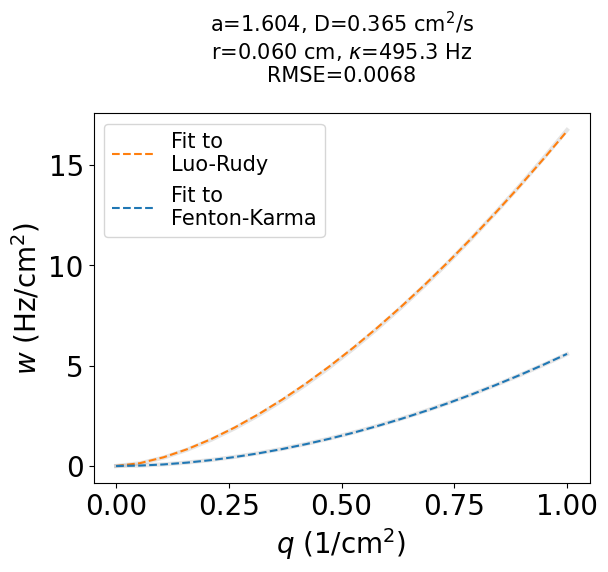

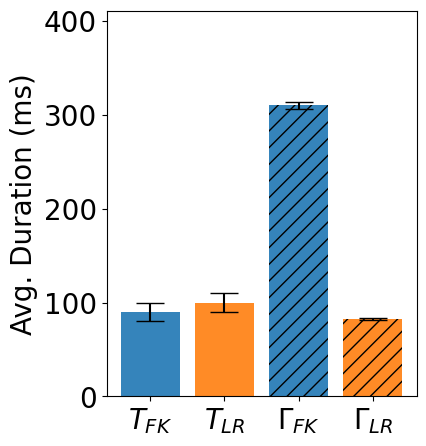

In [15]:
bar_height_values=np.array(mean_lst)
Delta_bar_height_values=np.array(Delta_mean_lst)
color_lst=['C0','C1','C0','C1']
bar_label_lst=[r'$T_{FK}$',r'$T_{LR}$',r'$\Gamma_{FK}$',r'$\Gamma_{LR}$']
# hatch: {'/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
hatch_values=np.array(['','','//','//'])
# bar_label_lst=['Audio-Only\n\n\n','Match\n\n\n','Mismatch\n\n\n','Video-Only\n\n\n']
ylabel='Avg. Duration (ms)'#\nwith Preferred Modality'
fig,ax=plt.subplots(figsize=(4,5))
ax.bar(bar_label_lst,bar_height_values,hatch=hatch_values,yerr=Delta_bar_height_values,alpha=0.9,color=color_lst,capsize=10)
# ax.errorbar(bar_label_lst[0],bar_height_values[0],Delta_bar_height_values[0],alpha=0.9,color=color_lst[0])
format_plot(ax=ax,xlabel='',ylabel=ylabel)
# title=''
# ax.set_title(title,fontsize=18)
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylim([0,410])
# plt.xticks(rotation=90)
# plt.xticks(rotation=0)
# plt.xticks(rotation=-90)
plt.show()

# analytic fit to MSR

$$
\text{MSR}_\text{Osc.}(t')=4at'+\frac{8D}{\omega}\Big(sin(\omega t' + \phi_f) - sin(\phi_f)\Big)
$$

In [17]:
msr_dir_lr=f'{nb_dir}/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083
msr_dir_fk=f'{nb_dir}/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

tmax=300#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8


NameError: name 'a_hat_LR' is not defined

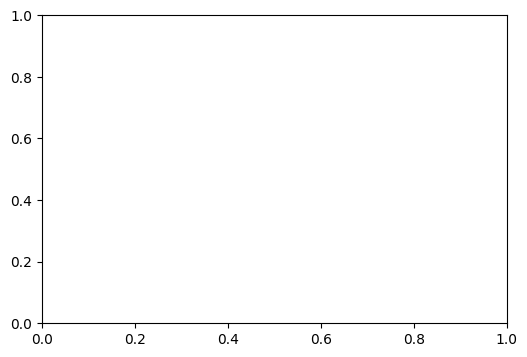

In [110]:
fontsize=15
fig,ax=plt.subplots(figsize=(6,4))
### plot expected
fontsize=20

xv=np.linspace(0,1e3,200)
ax.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
ax.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
ax.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;
phi_f=0.;
# phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values*1e3,MSR_values_oscillatory,c='C2',
        label='$MSR_{Osc.} (a=a_{LR},\phi_f=0$)')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values*1e3,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.} (a=a_{FK}, \phi_f=-\frac{\pi}{2})$')
#         label='$MSR_{Osc.} (a=a_{FK}, \phi_f=-\frac{\pi}{2})$')
#         label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=-\pi/2$)')

# #what param setting to use for the FK model?
# phi_f=0#-np.pi/2;
# # a=1.604153;
# # period=0.11 #s
# # D=a/2;
# # constant=0.15
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# plt.plot(t_values*1e3,MSR_values_oscillatory,c='gray',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=0$)')

#format plot
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
plt.xlim([0,1000])
plt.ylim([0,5.1])
plt.legend(loc='lower right',fontsize=fontsize-5,frameon=False)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

## generate MSR for the oscillatory model

In [ ]:
include_earliest=False#True#broken?

In [ ]:
#heretim
ahat_long=a_hat_FK_vlong#a_hat_LR_long
#Fenton-Karma
#GOAL: add a reasonable fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)
#DONE: initialize the particle model for the FK model
a=2.4; #2.5?
D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_FK,y_values_FK
# #DONE: initialize the particle model for the LR model
# a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_LR,y_values_LR
T=100#110#140#100#120#180#90#240
D=0.365238#	0.004171	101774+/-103689,0.6,1.5,0.98 # from particle properties spreadsheet
a=1.6
D=ahat_long/2#/1 #/4#/4
a=ahat_long#/2
#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

# initial_phase_orientation=phif
# initial_phase_orientation-=np.pi/2-np.pi# worse/4#/2
initial_phase_orientation+=np.pi/2

num_pairs=10000#1min 30sec: 10+1#400#2min 22sec: 
#before, long runtime
dict_out,position_array = gener_positions_oscillatory_reversed(
            a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation,
            include_earliest=include_earliest,
            period_of_oscillation=T)
print(*dict_out)
positions_out=position_array

#estimated run time: <1 minute
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt

t_values_fk_osc=t_values.copy()
MSR_values_fk_osc=MSR_values.copy()
beep(5)

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 10000)


In [ ]:
#heretim
ahat_long=a_hat_LR_long#a_hat_FK_vlong#
#Luo-Rudy
#runtime was ~40 seconds
#recompute the Luo-Rudy model's fitty for the MSR of the oscillatory model 
#GOAL: add a reasonable fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)
#DONE: initialize the particle model for the FK model
a=2.5; D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_FK,y_values_FK
#DONE: initialize the particle model for the LR model
a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
# x_values,y_values=x_values_LR,y_values_LR

#TODO: try to get a reasonable a for LR given D=D_LR
D=0.586055#	0.087553	1871+/-520,0,0.55*,0.89#from particle properties spreadsheet
a=5#too big 8.5#tad small...9#4.5#discontinuous... 5#too small... 3.8
T=120#100#240#120
D=ahat_long/2#/1 #/4
a=ahat_long
#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

initial_phase_orientation=phif
num_pairs=10000#1min 30sec: 10+1#400#2min 22sec: 
#before, long runtime
dict_out,position_array = gener_positions_oscillatory_reversed(
            a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation,
            include_earliest=include_earliest,
            period_of_oscillation=T)

print(*dict_out)
positions_out=position_array

#estimated run time: <1 minute
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt

t_values_lr_osc=t_values.copy()
MSR_values_lr_osc=MSR_values.copy()
beep(5)

In [ ]:
!pwd

In [ ]:
#DONE: save dotted as .npz
msr_osc_fn=f"msr_osc_full.npz"
np.savez_compressed(msr_osc_fn,
                   t_values_fk_osc=t_values_fk_osc,
                   MSR_values_fk_osc=MSR_values_fk_osc,
                   t_values_lr_osc=t_values_lr_osc,
                   MSR_values_lr_osc=MSR_values_lr_osc)
print(f"msr_osc_fn='{os.path.abspath(msr_osc_fn)}'")
assert os.path.exists(msr_osc_fn)

In [20]:
assert not np.isnan(Rsq_values).all()

False

## plot the results

In [21]:
#estimate a_sr expected for this value with a sliding window
msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083

msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

In [22]:
df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

In [23]:
tmax=300#8#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8


In [ ]:
#heretim
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot fitty
plt.plot(t_values_fk_osc*1e3,MSR_values_fk_osc,':',lw=2,alpha=0.5,c='C0')
plt.plot(t_values_lr_osc*1e3,MSR_values_lr_osc,':',lw=2,alpha=0.5,c='C1')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,180])
plt.ylim([0,3.1])
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
plt.title(title)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

In [ ]:
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

plt.plot(t_values_fk_osc*1e3,MSR_values_fk_osc,':',lw=2,alpha=0.5,c='C0')
plt.plot(t_values_lr_osc*1e3,MSR_values_lr_osc,':',lw=2,alpha=0.5,c='C1')

#this FAILS to let me change the text displayed...  i must make a triangle and a text box to make the slope's label "4a_FK"
# #mark the slope of ^that line with slope = 4*1.6 (FK) and slope = 4*8.6 (LR)
# x1 = 700
# y1 = 4
# ax=plt.gca()
# annotation.slope_marker(origin=(x1, y1),
#                         slope=4*1.6e-3,#(1.6,1),#1.6,
# #                         invert=True,
# #                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7, "text":'4a'},
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

#format plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1000])
plt.ylim([0,5.1])
# plt.ylim([0,4.1])

plt.show()

In [26]:
#TODO(later?): add a legend that identifies the 3 different classes of curves with black legend markers
# (solid) full model, 
# (dashed) interacting inverse-powerlaw particle model,
# (dotted) oscillatory particle model,

In [27]:
#GOAL: highlight ^this with slopes indicating how ahat is computed 
# #TODO: change label to 4*a
# annotation.slope_marker? #LAME
# matplotlib.text.Text? #object oriented
# matplotlib.patches.Polygon? #object oriented
# #HINT: use ^these two mpl handles to add slopes to indicate 

In [6]:
1.604153/2

0.8020765

In [5]:
Tavg_expected_lr=1e-03/0.095638665 #seconds #N=10, L=5
print(f"Tavg_expected_lr={Tavg_expected_lr} when N=10, L=5")
Tavg_expected_lr=1e-03/0.18501388 #seconds N=16, L=5
print(f"Tavg_expected_lr={Tavg_expected_lr} when N=16, L=5")
# src: src: full_results/data_fig4_vidmar_lr_tt.csv

Tavg_expected_lr=0.0104560221538015 when N=10, L=5
Tavg_expected_lr=0.005404999884333002 when N=16, L=5


## (ignore) (example msr traces from oscillatory) generate traces of MSR from the oscilatory model that are reasonable guesses for the full models
DONT dev nelder-mead least square fits of the oscillatory model to the MSR of the full models

In [28]:
#GOAL: add a best fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)


#DONE: initialize the particle model for the FK model
a=2.5; D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_FK,y_values_FK
#DONE: initialize the particle model for the LR model
a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_LR,y_values_LR

#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

In [29]:
#     #2 min. runtime?
testing=True
initial_phase_orientation=phif
num_pairs=50#1min 30sec: 10+1#400#2min 22sec: 
if testing:
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    positions_out=position_array
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 50)


In [30]:
#GOAL: add a reasonable fit MSR from the reversed-time oscillatory particle model (dotted)
#DONE: select either of the xy values form the full model (OR copy & paste ^that to new ipynb)
#DONE: initialize the particle model for the FK model
a=2.5; D=1.2; T=120; phif=0.0003; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_FK,y_values_FK
#DONE: initialize the particle model for the LR model
a=3.8; D=1.9; T=120; phif=0.0002; Rf=1e-02; Ntrials=1000
x_values,y_values=x_values_LR,y_values_LR

#TODO: recall my time reversed function that maps parameters of the oscillatory model to MSR
# gener_positions_oscillatory_reversed

initial_phase_orientation=phif
num_pairs=1000#1min 30sec: 10+1#400#2min 22sec: 
#before, long runtime
dict_out,position_array = gener_positions_oscillatory_reversed(
            a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
print(*dict_out)
positions_out=position_array

#estimated run time: <1 minute
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt

t_values_lr_osc=t_values.copy()
MSR_values_lr_osc=MSR_values.copy()
beep(5)

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)


0

In [31]:
#     #2 min. runtime?
testing=True
initial_phase_orientation=phif
num_pairs=200#1min 30sec: 10+1#400#2min 22sec: 
if testing:
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    positions_out=position_array
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 200)


In [32]:
#     #2 min. runtime?
testing=True
initial_phase_orientation=phif
num_pairs=100#1min 30sec: 10+1#400#2min 22sec: 
if testing:
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    positions_out=position_array
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 100)


In [33]:
#TODO: average ^that N=1000 run.
print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)

positions_out.shape=(100000, 4, 100)


In [34]:
plt.plot(MSR_values)

In [35]:
MSR_values_high_res=MSR_values.copy()
MSR_values_high_res.shape

(100000,)

positions_out.shape=(100000, 4, 100)


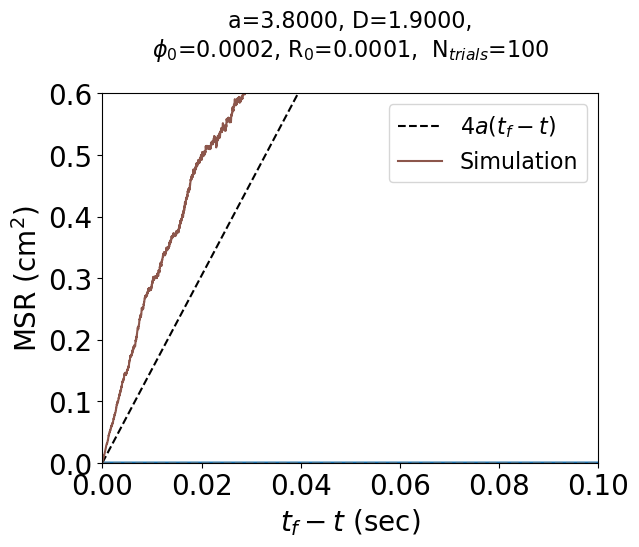

In [36]:
#estimated run time: 11 minutes


# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"



print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt
# x_values=aligned_mean_values[:,0]
# plt.plot(aligned_mean_values[:,1])
# plt.plot(aligned_mean_values[:,2])
# plt.plot(aligned_mean_values[:,3])

xmin,xmax=0,0.1
ymin,ymax=0,0.6
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(t_values,MSR_values,c='C5',label=r"Simulation")
# plt.plot(t_values,aligned_mean_values[::-1,0]**2)
plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.title(title,fontsize=16)
plt.legend(fontsize=16)
plt.show()




In [37]:

boo=~(np.isnan(t_values)|np.isnan(MSR_values))
dict_fit=compute_95CI_ols(t_values[boo],MSR_values[boo])
print_dict(dict_fit)
print(f"num_samples={positions_out.shape[-1]}")
print(f"num_timepoints={t_values.shape[0]}")
print(f"ahat = {dict_fit['m']/4:.4f}+/-{dict_fit['Delta_m']/4:.4f}")

m=15.687366825275118
Delta_m=0.006563160827167656
b=-0.09775733309437928
Delta_b=0.003789214250968185
Rsquared=0.9954644400547724
num_samples=100
num_timepoints=100000
ahat = 3.9218+/-0.0016


In [38]:
#TODO: recall my Nelder-Mead least-squares minimization routine
#TODO: merge ^those two routines
#TODO: plot the MSR of the resulting fit (if Nelder-Mead is sufficiently awesome)

In [39]:
meanT_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/luorudy_mean_kinematic_periods.npz'
meanT_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/fentonkarma_mean_kinematic_periods.npz'
np.mean(meanT_values)

NameError: name 'meanT_values' is not defined

# generate figure for the mslim consistency argument

In [3]:
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()
# note: a_ratio_lr=a_hat_FK_vlong/a_hat_FK_vlong=1
ahat_fk_observed=a_hat_FK_vlong
D_hat_fk_observed=D_hat_FK
ahat_lr_observed=a_hat_LR
D_hat_lr_observed=D_hat_LR
a_lr_observed=a_hat_LR_long
a_fk_observed=a_hat_FK_vlong

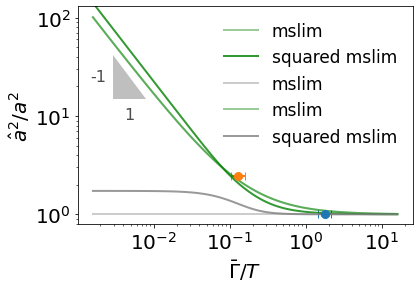

In [4]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
#plot observed ahat,Gamma/T values as horizontal dashed lines
#Fenton-Karma
# GammaBar_observed: 387.0374+/-31.3052/2 milliseconds
# T:110 +/- ?? ms
a=197.3891#ms
Delta_GammaBar_observed=35.600166 #ms
# a=387.0374#ms
# Delta_GammaBar_observed=15.6526#ms
b=110#ms
Delta_T_estimated=10
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_fk_observed/a_fk_observed)
Delta_y=.04 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=2,
            color='C0')#,label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
#Luo-Rudy
# GammaBar_observed: 41.9756+/-4.4809/2 milliseconds
# T:120 +/- ?? mc
# a=41.9756#ms
# Delta_GammaBar_observed=15.6526
a=15.5618 #ms
Delta_GammaBar_observed=1.867684
Delta_T_estimated=20
b=120#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_lr_observed/a_lr_observed)
Delta_y=.08 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=2,
            color='C1')#,label='Luo-Rudy')


#MSLIM
#plot predictions for phi=-np.pi/2
phi=phi_f
a=1 #same plot for any a
y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=phi)/a
ax.plot(x_values,y_values,lw=2,alpha=0.4,color='green',
                label=r'mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
        label=r'squared mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
# #plot predictions for phi=0
# phi=0
a=1 #same plot for any a
y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=0)/a
ax.plot(x_values,y_values,lw=2,alpha=0.4,color='grey',
                label=r'mslim')

y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=phi)/a
ax.plot(x_values,y_values,lw=2,alpha=0.4,color='green',
                label=r'mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=0)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=0)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
        label=r'squared mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')

#SMSLIM
# #plot predictions for phi=-np.pi/2
# phi=phi_f
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
# #         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
# #         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
# #plot predictions for phi=0
# phi=0
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# x_values=z_values/(2.*np.pi)
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
#         label=r'$g(\bar\Gamma/T,\phi_f=0)$')
# #         label=r'g($\phi_f=0$)')
# #         label=r'Solution ($\phi_f=0$)')



#DONE: copy estimates from .odg
#DONE: add error bar estimates
#TODO(later): consider improving x,Delta_x estimates
#TODO: plot the diffusion correction divided by the cross correction
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')
fontsize=20

#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
plt.ylim([8e-1,1.3e2])
ax.legend(loc='upper right',fontsize=fontsize-3,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=fontsize)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
# mark_slope(ax=ax,x1=1e-2,y1=2e1,slope=(-1,1),invert=True)
mark_slope(ax=ax,x1=.8e-2,y1=1.5e1,slope=(-1,1),invert=True)
plt.show()

In [11]:
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [418]:
# #(DEPRECATED # comp_ahat_mslim
# # dasum=np.exp(1j*phi)/(1-1j*z)
# # dasum-=np.exp(-1j*phi)/(1+1j*z)
# # dasum-=np.sin(phi)
# # ahat=a+2*D/z*dasum.astype('float')
# # return ahat
# comp_alinear?

In [413]:
# # #heretim
# comp_alinear
# #TODO: modify this to give the correct universal relation
# def comp_alinear(z,a,D,phi):
# #     """
# #     correction_mslim returns the real correction value
# #     that evaluates the expected attraction coefficient
# #     in terms of the parameters of the oscilatory model
# #     relative to the lifetime of the particle.

# #     here, the lifetime of the particle has been taken
# #     to be exponentially distributed
# #     with an expected value
# #     proportional to z.

# #     Note that z is also
# #     inversely proportional
# #     to the dynamic period of oscillation.
# #     """
# #     dasum=np.exp(1j*phi)/(1-1j*z)
# #     dasum-=np.exp(-1j*phi)/(1+1j*z)
# #     dasum-=np.sin(phi)
# #     ahat=a+2*D/z*dasum.astype('float')
# #     return ahat

In [ ]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
fontsize=20
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

alinear = comp_alinear(a0=dict_osc_fit_fk['a0'],
                       a1=dict_osc_fit_fk['a1'],
                       period=dict_osc_fit_fk['period'],
                       Gamma=dict_osc_fit_fk['a0'],
                       phase=dict_osc_fit_fk['a0'],)

In [420]:
dict_osc_fit_fk['a0']

{'a0': 1.6361678784211904,
 'a1': 1.2822207795221772,
 'period': 115.94132757652915,
 'phase': -0.5414831911503737,
 'rmse': 0.028433802911998075,
 'alinear': 1.7812325245076142,
 'omega': 0.054192801122035256,
 'z': 5.707561428236097}

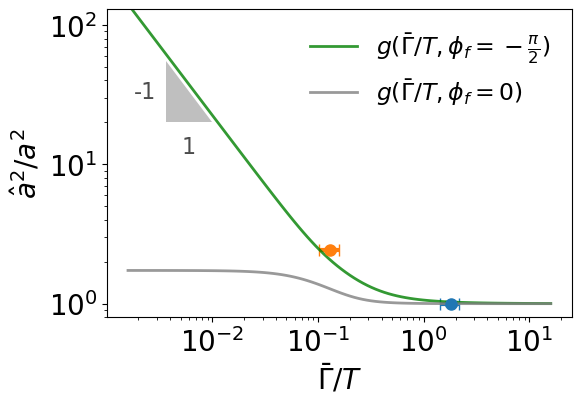

In [13]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
fontsize=20
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
#plot observed ahat,Gamma/T values as horizontal dashed lines
#Fenton-Karma
# GammaBar_observed: 387.0374+/-31.3052/2 milliseconds
# T:110 +/- ?? ms
a=197.3891#ms
Delta_GammaBar_observed=35.600166 #ms
# a=387.0374#ms
# Delta_GammaBar_observed=15.6526#ms
b=110#ms
Delta_T_estimated=10
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_fk_observed/a_fk_observed)
Delta_y=.04 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=3,
            color='C0')#,label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
#Luo-Rudy
# GammaBar_observed: 41.9756+/-4.4809/2 milliseconds
# T:120 +/- ?? mc
# a=41.9756#ms
# Delta_GammaBar_observed=15.6526
a=15.5618 #ms
Delta_GammaBar_observed=1.867684
Delta_T_estimated=20
b=120#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_lr_observed/a_lr_observed)
Delta_y=.08 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=3,
            color='C1')#,label='Luo-Rudy')


#MSLIM
#plot predictions for phi=-np.pi/2
phi=phi_f
a=1 #same plot for any a
# y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=phi)/a
# ax.plot(x_values,y_values,lw=2,alpha=0.4,color='green',
#                 label=r'mslim')
# #         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
#         label=r'squared mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
# #plot predictions for phi=0
# phi=0
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# x_values=z_values/(2.*np.pi)
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
#         label=r'$g(\bar\Gamma/T,\phi_f=0)$')
# #         label=r'g($\phi_f=0$)')
# #         label=r'Solution ($\phi_f=0$)')

# SMSLIM
#plot predictions for phi=-np.pi/2
phi=phi_f
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
        label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
#plot predictions for phi=0
phi=0
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
x_values=z_values/(2.*np.pi)
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
        label=r'$g(\bar\Gamma/T,\phi_f=0)$')
#         label=r'g($\phi_f=0$)')
#         label=r'Solution ($\phi_f=0$)')



#DONE: copy estimates from .odg
#DONE: add error bar estimates
#TODO(later): consider improving x,Delta_x estimates
#TODO: plot the diffusion correction divided by the cross correction
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
plt.ylim([8e-1,1.3e2])
ax.legend(loc='upper right',fontsize=fontsize-3,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=fontsize)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
mark_slope(ax=ax,x1=1e-2,y1=2e1,slope=(-1,1),invert=True)
# mark_slope(ax=ax,x1=.8e-2,y1=1.5e1,slope=(-1,1),invert=True)
plt.show()

In [14]:
#src
# http://localhost:8888/notebooks/python/Notes%20on%20fitting%20the%20oscillatory%20particle%20model%20to%20the%20linear%20particle%20model.ipynb


 # generation of lifetimes histogram
 TODO: copy src from care in 
    `http://localhost:8889/notebooks/Lifetimes%20of%20Spiral%20Tips.ipynb`

In [21]:
#DONE: save results as pkl
import pickle

# dict_lifetimes = {'lr': {'tbins':bins, 'pdf_bar_heights':bar_heights_lr},
#      'fk': {'tbins':bins, 'pdf_bar_heights':bar_heights_fk}
#     }

lifetime_pdf_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/lifetimes.pkl"

with open(lifetime_pdf_dir, 'rb') as handle:
    dict_lifetimes = pickle.load(handle)

In [ ]:
alpha=0.8
# bins=300
# bins='doane'
# bins='rice'
# bins='sqrt'
bins=np.arange(0,4e3,60)
# 'auto', 'fd', 'doane',
#     'scott', 'stone', 'rice', 'sturges', or 'sqrt'.

#figure panel style histogram of lifetimes
fig,ax=plt.subplots(figsize=(6,5))
bar_heights_fk,bins,_=plt.hist(lifetime_values_FK,bins=bins,log=True,color='C0',density=True,alpha=alpha, label='Fenton-Karma Model')
bar_heights_lr,_,_=plt.hist(lifetime_values_LR,bins=bins,log=True,color='C1',density=True,alpha=alpha, label='Luo-Rudy Model')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel='Lifetime (ms)',ylabel='PDF')
plt.show()